In [1]:
import os
import json

import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Global Wheat Detection Dataset EDA

## Download Dataset

In [ ]:
!pip install aicrowd-cli

In [ ]:
API_KEY = "" 
!aicrowd login --api-key $API_KEY

In [ ]:
!aicrowd dataset download --challenge global-wheat-challenge-2021

In [ ]:
!mkdir -p ../data/gwhd

In [ ]:
!unzip train.zip -d ../data/gwhd
!rm train.zip

In [ ]:
!unzip test.zip -d ../data/gwhd
!rm test.zip

## General Dataset Information

**Load dataset**

In [2]:
DATA_ROOT = '../data/gwhd'

In [3]:
data = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))
data.tail()

image_name  \
3652  a7a7fc8914a720073e2bad3f2981a869ea54a0eba3adde...   
3653  303cfef6aa1483f7377292eac942b2c80ef17d8ab347ed...   
3654  99ecf64fab884c431969a12eb28ad29041aa190498d3ae...   
3655  a543d8ab29e27fbd7fd96fa5f48ed2e84592c1372583bc...   
3656  618d3e5f3a932a9b6c877976ce9e512a6229b63b38bab8...   

                                            BoxesString  domain  
3652  950 137 1024 267;375 545 478 621;49 155 203 21...      17  
3653  624 897 696 960;759 534 847 665;656 975 730 10...      17  
3654  318 354 385 414;528 0 597 50;674 948 754 1024;...      17  
3655  734 56 822 134;1 661 151 803;942 613 1024 708;...      17  
3656  455 227 525 282;426 846 534 916;79 169 155 275...      17

**Decode `BoxesString`**

In [9]:
def decodeString(BoxesString):
      """
      Small method to decode the BoxesString
      """
      if BoxesString == "no_box":
          return np.zeros((0,4))
      else:
          try:
              boxes =  np.array([np.array([int(i) for i in box.split(" ")])
                              for box in BoxesString.split(";")])
              return boxes
          except:
              print(BoxesString)
              print("Submission is not well formatted. empty boxes will be returned")
              return np.zeros((0,4))

In [5]:
boxes = [decodeString(item) for item in data["BoxesString"]]
data["boxes"] = boxes
data.tail()

image_name  \
3652  a7a7fc8914a720073e2bad3f2981a869ea54a0eba3adde...   
3653  303cfef6aa1483f7377292eac942b2c80ef17d8ab347ed...   
3654  99ecf64fab884c431969a12eb28ad29041aa190498d3ae...   
3655  a543d8ab29e27fbd7fd96fa5f48ed2e84592c1372583bc...   
3656  618d3e5f3a932a9b6c877976ce9e512a6229b63b38bab8...   

                                            BoxesString  domain  \
3652  950 137 1024 267;375 545 478 621;49 155 203 21...      17   
3653  624 897 696 960;759 534 847 665;656 975 730 10...      17   
3654  318 354 385 414;528 0 597 50;674 948 754 1024;...      17   
3655  734 56 822 134;1 661 151 803;942 613 1024 708;...      17   
3656  455 227 525 282;426 846 534 916;79 169 155 275...      17   

                                                  boxes  
3652  [[950, 137, 1024, 267], [375, 545, 478, 621], ...  
3653  [[624, 897, 696, 960], [759, 534, 847, 665], [...  
3654  [[318, 354, 385, 414], [528, 0, 597, 50], [674...  
3655  [[734, 56, 822, 134], [1, 661, 151, 803], [942...  
3656  [[455, 227, 525, 282], [426, 846, 534, 916], [...

### Basic data stats

**Count the number of images in the train set**

In [6]:
print('There are {} images in the train set'.format(len(data)))


There are 3657 images in the train set


**Compute the average number of labeled wheat heads (bounding boxes) per image**

In [7]:
box_count = sum([len(listElem) for listElem in boxes])

In [8]:

print('On average, there are {} boxes per image'.format(round(box_count / len(data), 2)))



On average, there are 44.76 boxes per image


**Count the number of images without bounding boxes**

In [9]:
no_boxes = data.loc[data['BoxesString'] == 'no_box']

In [10]:
print('There are {} images without wheat heads.'.format(len(no_boxes)))

There are 50 images without wheat heads.


**Count the number of bounding boxes per image**

In [11]:
counts = []

for index in tqdm(range(len(data))):
  row = data.iloc[index]
  img_name = row.image_name
  count = len(row.boxes)

  counts.append([img_name, count])

boxes_per_image = pd.DataFrame(counts, columns=["image_id", "count"])

/home/ogidif/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/3657 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

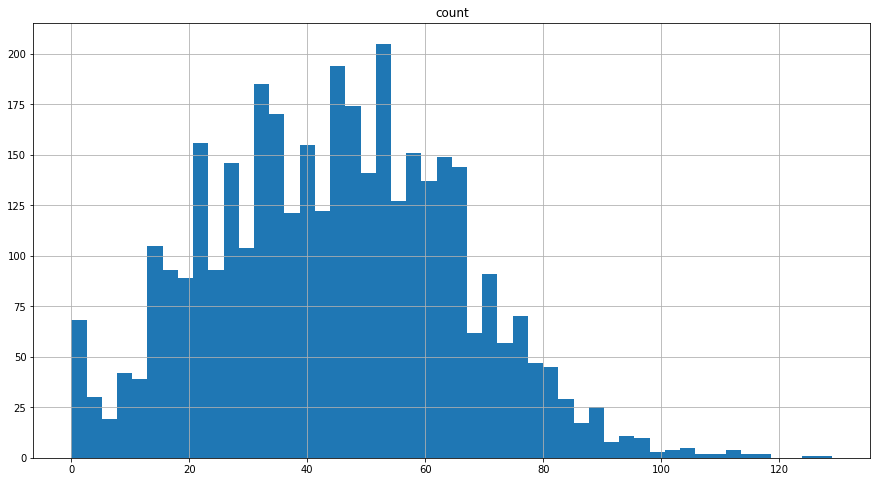

In [12]:
boxes_per_image.hist(bins=50, figsize=(15, 8))

**Get the distribution of bounding box sizes**

In [13]:
# compute area of bounding boxes

def compute_area(bbox):
    box_w = bbox[2] - bbox[0]
    box_h = bbox[3] - bbox[1]
    return box_w * box_h

box_areas = []
for listElem in boxes:
    box_areas.append([compute_area(bbox) for bbox in listElem])

data['box_areas'] = box_areas
data.tail()

image_name  \
3652  a7a7fc8914a720073e2bad3f2981a869ea54a0eba3adde...   
3653  303cfef6aa1483f7377292eac942b2c80ef17d8ab347ed...   
3654  99ecf64fab884c431969a12eb28ad29041aa190498d3ae...   
3655  a543d8ab29e27fbd7fd96fa5f48ed2e84592c1372583bc...   
3656  618d3e5f3a932a9b6c877976ce9e512a6229b63b38bab8...   

                                            BoxesString  domain  \
3652  950 137 1024 267;375 545 478 621;49 155 203 21...      17   
3653  624 897 696 960;759 534 847 665;656 975 730 10...      17   
3654  318 354 385 414;528 0 597 50;674 948 754 1024;...      17   
3655  734 56 822 134;1 661 151 803;942 613 1024 708;...      17   
3656  455 227 525 282;426 846 534 916;79 169 155 275...      17   

                                                  boxes  \
3652  [[950, 137, 1024, 267], [375, 545, 478, 621], ...   
3653  [[624, 897, 696, 960], [759, 534, 847, 665], [...   
3654  [[318, 354, 385, 414], [528, 0, 597, 50], [674...   
3655  [[734, 56, 822, 134], [1, 661, 151, 803], [942...   
3656  [[455, 227, 525, 282], [426, 846, 534, 916], [...   

                                              box_areas  
3652  [9620, 7828, 8778, 15345, 3127, 8547, 9072, 72...  
3653  [4536, 11528, 3626, 3920, 5896, 6000, 11786, 5...  
3654  [4020, 3450, 6080, 6536, 1196, 8272, 7469, 666...  
3655  [6864, 21300, 7790, 9990, 4544, 16428, 8811, 3...  
3656  [3850, 7560, 8056, 3828, 5822, 9879, 5548, 696...

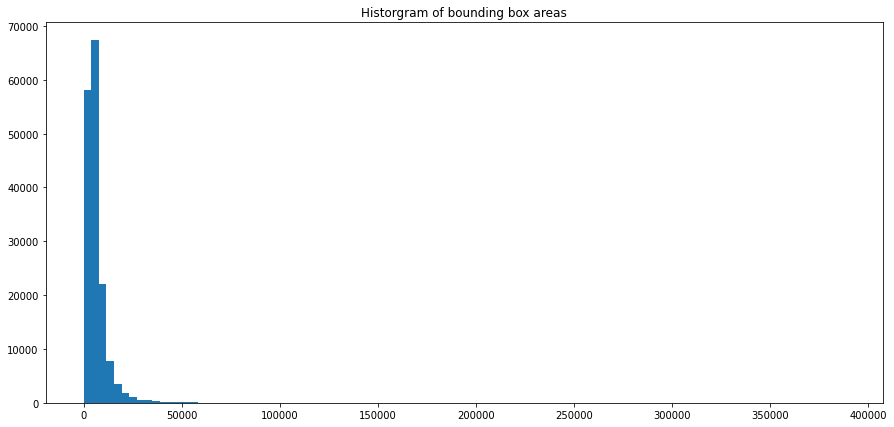

In [14]:
bbox_areas = np.array([elem for sub_list in box_areas for elem in sub_list])

plt.figure(figsize=(15, 7))
plt.hist(bbox_areas, bins=100)
plt.title('Historgram of bounding box areas')
plt.show()

In [15]:
box_area_df = pd.DataFrame(bbox_areas)
box_area_df.describe()

0
count  163690.000000
mean     6377.742654
std      5939.688626
min        24.000000
25%      3198.000000
50%      4914.000000
75%      7524.000000
max    387960.000000

### Data Visualization

In [16]:
# helper functions
def get_all_bboxes(data, image_id):
    '''
    Get all bouding boxes for a given image_id
    '''
    bboxes = data.loc[data['image_name'] == image_id].boxes.values[0]
    return bboxes

def plot_image_examples(data, rows=3, cols=3, title='Image examples', root=DATA_ROOT):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 12))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(data), size=1)[0]
            img_id = data.iloc[idx].image_name
            
            img = cv2.imread(os.path.join(root, 'train', img_id + '.png'))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            bboxes = get_all_bboxes(data, img_id)
            
            # draw the bounding boxes
            for bbox in bboxes:
                cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255, 0, 0), 5)
              
            axs[row, col].imshow(img)
            axs[row, col].axis('off')
            axs[row, col].set_aspect('equal')
    plt.suptitle(title)
    plt.tight_layout()

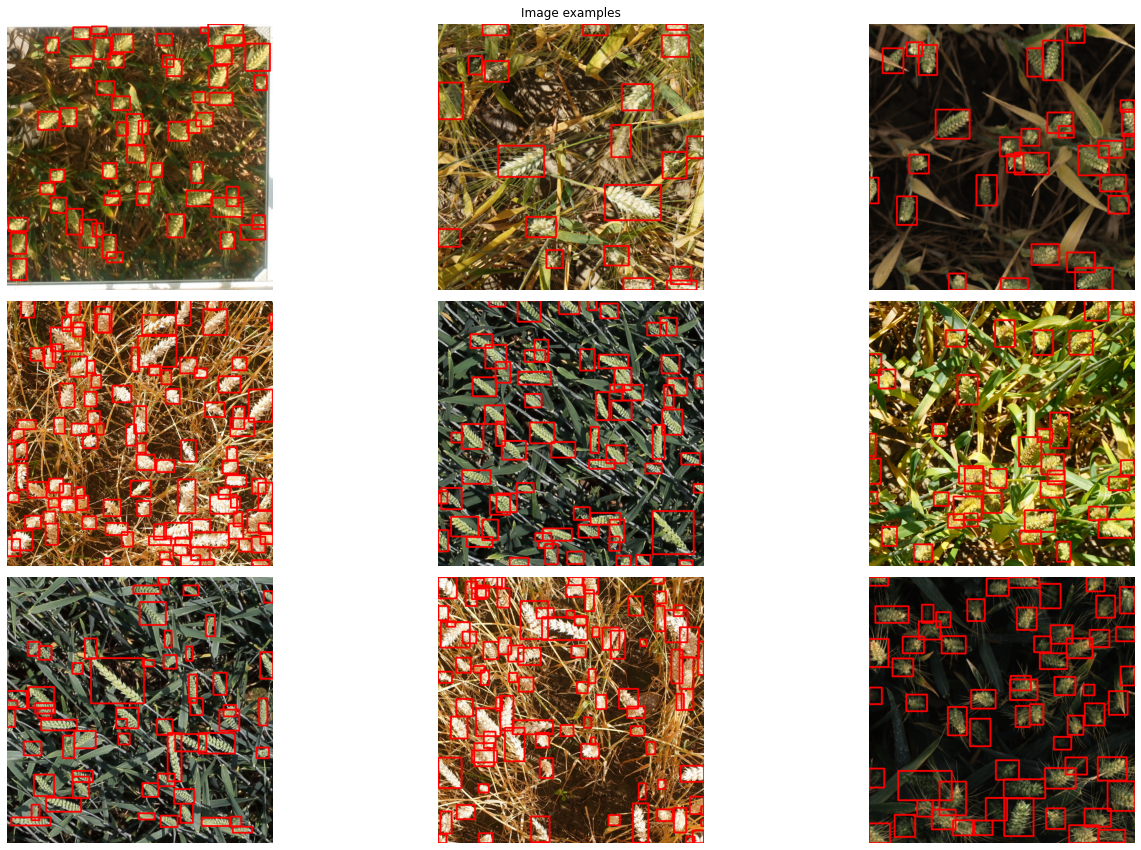

In [17]:
plot_image_examples(data)

**Plot some images with fewer bounding boxes than average**

In [18]:
data['box_count'] = boxes_per_image['count'].to_list()
data.tail()

image_name  \
3652  a7a7fc8914a720073e2bad3f2981a869ea54a0eba3adde...   
3653  303cfef6aa1483f7377292eac942b2c80ef17d8ab347ed...   
3654  99ecf64fab884c431969a12eb28ad29041aa190498d3ae...   
3655  a543d8ab29e27fbd7fd96fa5f48ed2e84592c1372583bc...   
3656  618d3e5f3a932a9b6c877976ce9e512a6229b63b38bab8...   

                                            BoxesString  domain  \
3652  950 137 1024 267;375 545 478 621;49 155 203 21...      17   
3653  624 897 696 960;759 534 847 665;656 975 730 10...      17   
3654  318 354 385 414;528 0 597 50;674 948 754 1024;...      17   
3655  734 56 822 134;1 661 151 803;942 613 1024 708;...      17   
3656  455 227 525 282;426 846 534 916;79 169 155 275...      17   

                                                  boxes  \
3652  [[950, 137, 1024, 267], [375, 545, 478, 621], ...   
3653  [[624, 897, 696, 960], [759, 534, 847, 665], [...   
3654  [[318, 354, 385, 414], [528, 0, 597, 50], [674...   
3655  [[734, 56, 822, 134], [1, 661, 151, 803], [942...   
3656  [[455, 227, 525, 282], [426, 846, 534, 916], [...   

                                              box_areas  box_count  
3652  [9620, 7828, 8778, 15345, 3127, 8547, 9072, 72...         37  
3653  [4536, 11528, 3626, 3920, 5896, 6000, 11786, 5...         42  
3654  [4020, 3450, 6080, 6536, 1196, 8272, 7469, 666...         47  
3655  [6864, 21300, 7790, 9990, 4544, 16428, 8811, 3...         25  
3656  [3850, 7560, 8056, 3828, 5822, 9879, 5548, 696...         53

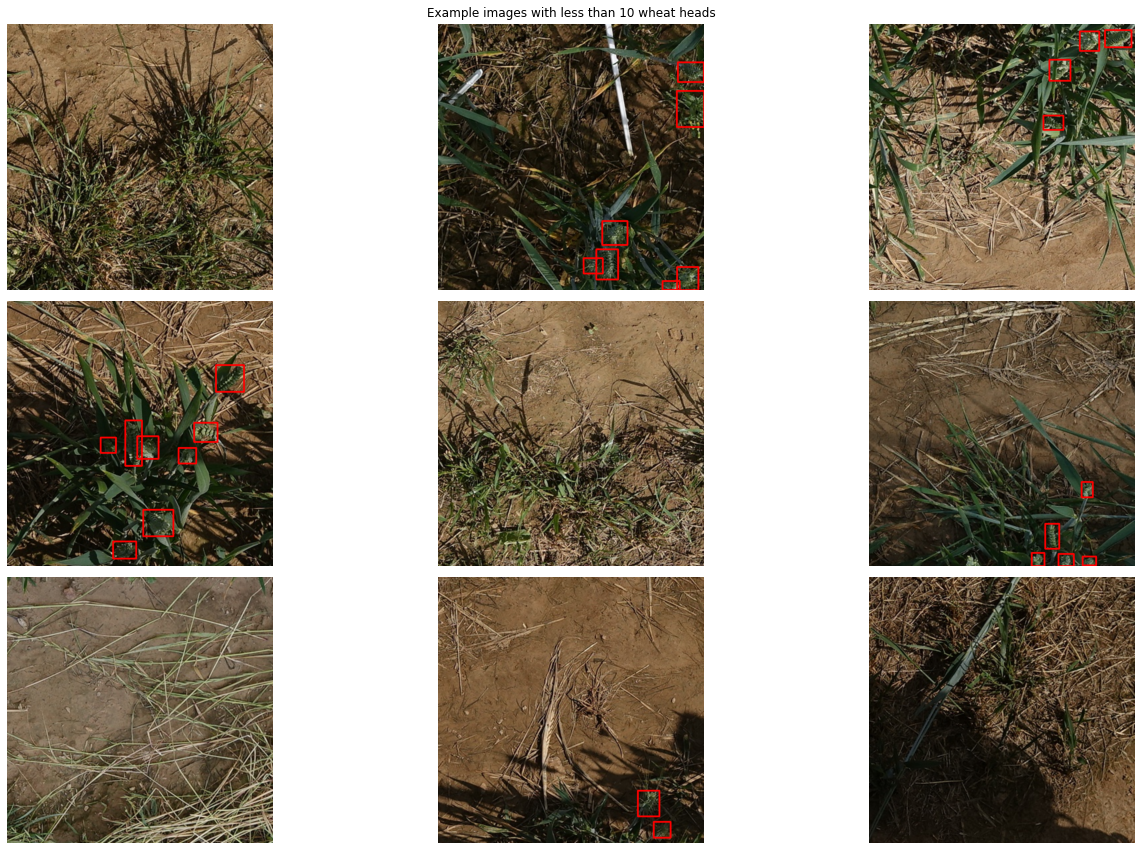

In [19]:
imgs_with_fewer_boxes = data.loc[data['box_count'] < 10]
plot_image_examples(imgs_with_fewer_boxes, title='Example images with less than 10 wheat heads')

**Plot some images with more bounding boxes than average**

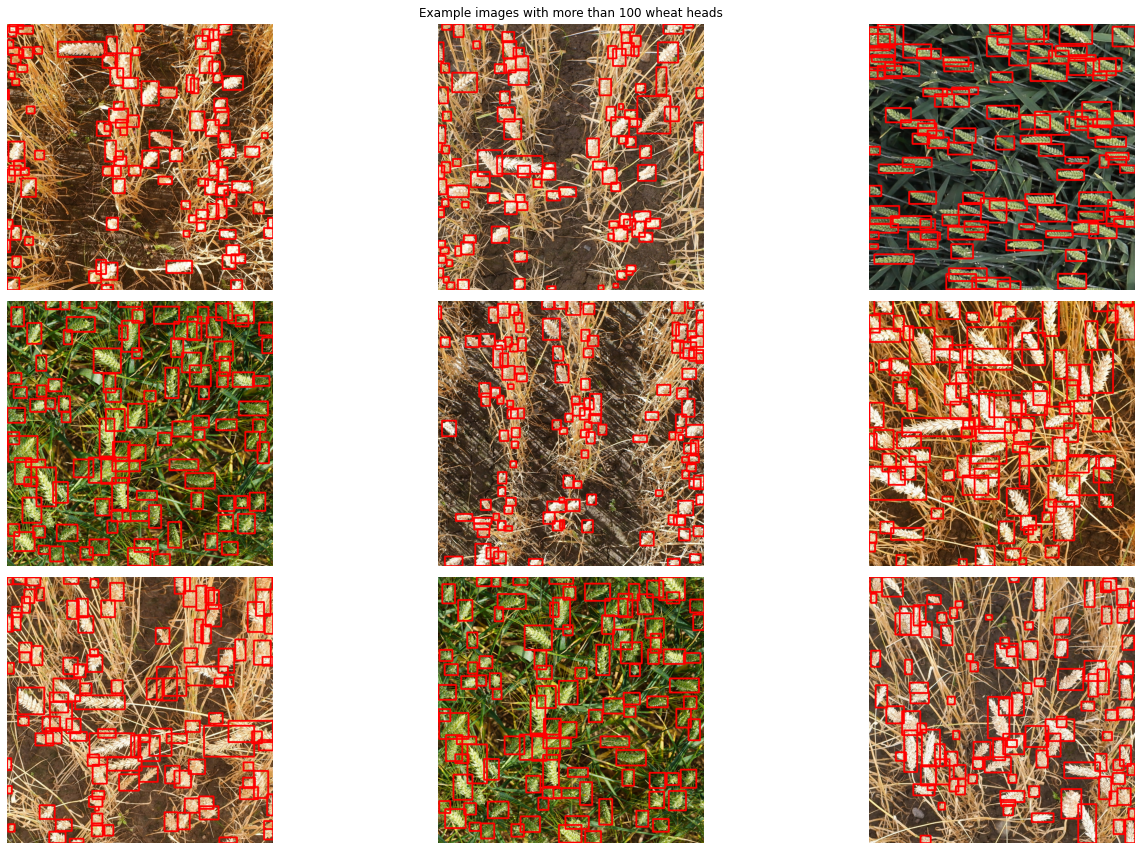

In [20]:
imgs_with_more_boxes = data.loc[data['box_count'] > 100]
plot_image_examples(imgs_with_more_boxes, title='Example images with more than 100 wheat heads')

## Split training data and convert annotations to coco

In [3]:
from sklearn.model_selection import StratifiedKFold

def split(data, seed=42):
  skf = StratifiedKFold(n_splits=5, shuffle=False)
  split = skf.split(data["image_name"], data["domain"])
  train_indices, val_indices = split.__next__()
  
  return train_indices, val_indices

In [4]:
ANNOTATIONS_DIR = os.path.join(DATA_ROOT, 'annotations')
if not os.path.exists(ANNOTATIONS_DIR):
    os.makedirs(ANNOTATIONS_DIR)

In [6]:
# load annotations, again
dataset = pd.read_csv(os.path.join(DATA_ROOT, 'train.csv'))

# split the training set using the stratified k-fold cross-validation
# method, so the the distribution of image domains is maintained
train_indices, val_indices = split(dataset)

# write new data splits to disk
train_df = dataset.iloc[train_indices].reset_index(drop=True)
train_df.to_csv(os.path.join(ANNOTATIONS_DIR, "train.csv"), index=False)

val_df = dataset.iloc[val_indices].reset_index(drop=True)
val_df.to_csv(os.path.join(ANNOTATIONS_DIR, "val.csv"), index=False)


In [7]:
def xyxy2xywh(boxes):
  y = np.copy(boxes)
  y[:, 2] = boxes[:, 2] - boxes[:, 0]  # width
  y[:, 3] = boxes[:, 3] - boxes[:, 1]  # height
  return y

def convert_to_coco(df, root_dir):
  ann = {
    'images': [],
    'annotations': [],
    'categories': [{"id": 0, "name": "wheat_head", "supercategory": None}]
  }
  img_names = [img_name for img_name in df['image_name']]
  ann_count = 0

  for idx, img_name in enumerate(img_names):
    img = cv2.imread(os.path.join(root_dir, 'train', img_name + '.png'))
    width = img.shape[1]
    height = img.shape[0]

    ann['images'].append({
      'id': idx,
      'width': width,
      'height': height,
      'file_name': img_name + '.png'
    })

    boxes_string = df.loc[df['image_name'] == img_name].BoxesString.values[0]
    bboxes = decodeString(boxes_string)
    coco_bboxes = xyxy2xywh(bboxes)

    for box in coco_bboxes:
      ann['annotations'].append({
        "id": ann_count,
        "image_id": idx,
        "category_id": 0,
        "segmentation": None,
        "area": float(box[2] * box[3]),
        "bbox": box.tolist(),
        "iscrowd": 0,
      })
      ann_count += 1

  return ann

In [10]:
train_ann = convert_to_coco(train_df, DATA_ROOT)
val_ann = convert_to_coco(val_df, DATA_ROOT)

with open(os.path.join(ANNOTATIONS_DIR, 'train.json'), 'w') as f:
    json.dump(train_ann, f)

with open(os.path.join(ANNOTATIONS_DIR, 'val.json'), 'w') as f:
    json.dump(val_ann, f)
print('Done!')

Done!
